In [1]:
import api_test_0731 as api
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import neuralgym as ng
from inpaint_model import InpaintCAModel

[2018-09-09 00:57:31 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-09-09 00:57:31 @__init__.py:80] Saving logging to file: neuralgym_logs/20180909005731013629.


In [2]:
#args_checkpoint_dir = 'model_logs/release_imagenet_256'
#args_checkpoint_dir = 'model_logs/release_celeba_256'
#args_checkpoint_dir = 'model_logs/release_celeba_hq_256'
args_checkpoint_dir = 'model_logs/release_places2_256'
#args_output = 'examples/output.png'

In [3]:
ID = 10

Step 1: 從 PIXNET 拿比賽題目

題號： 10
文字描述： 義大利麵裡又藏有許多四季豆和菇類讓整體充滿多層次的美味
Bounding Box: {'x': 36, 'y': 65, 'w': 109, 'h': 93}
影像物件： <class 'numpy.ndarray'> uint8 , 影像大小： (256, 256, 3)


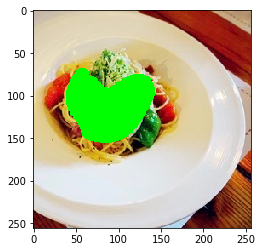

In [4]:
quiz = api.get_image(ID)
raw = quiz.raw_image
bbox = quiz.bbox
plt.imshow(raw)

In [5]:
def image_n_mask(raw, bbox):
    mask = np.zeros((raw.shape), dtype=np.float32)
    raw_roi = raw[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w'], :]
    mask_roi = mask[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w'], :]
    for i in range(raw_roi.shape[0]):
        for j in range(raw_roi.shape[1]):
            if (raw_roi[i,j] == np.array([0, 255, 0])).all():
                raw_roi[i,j] = np.array([255, 255, 255], dtype=np.float32)
                mask_roi[i,j] = np.array([255, 255, 255], dtype=np.float32)
    raw[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w'], :] = raw_roi
    mask[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w'], :] = mask_roi
    return raw, mask

image, mask = image_n_mask(raw, bbox)

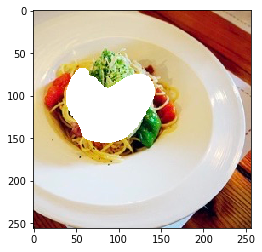

In [6]:
plt.imshow(image)

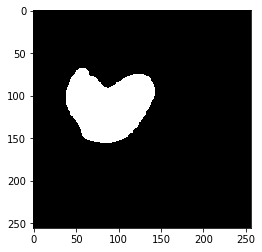

In [7]:
plt.imshow(mask)

In [8]:
def test(image, mask):
    ng.get_gpus(1)
    #args = parser.parse_args()

    model = InpaintCAModel()
    #image = cv2.imread(args.image)
    #mask = cv2.imread(args.mask)

    assert image.shape == mask.shape

    h, w, _ = image.shape
    grid = 8
    image = image[:h//grid*grid, :w//grid*grid, :]
    mask = mask[:h//grid*grid, :w//grid*grid, :]
    print('Shape of image: {}'.format(image.shape))

    image = np.expand_dims(image, 0)
    mask = np.expand_dims(mask, 0)
    input_image = np.concatenate([image, mask], axis=2)

    sess_config = tf.ConfigProto()
    sess_config.gpu_options.allow_growth = True
    with tf.Session(config=sess_config) as sess:
        input_image = tf.constant(input_image, dtype=tf.float32)
        output = model.build_server_graph(input_image)
        output = (output + 1.) * 127.5
        output = tf.reverse(output, [-1])
        output = tf.saturate_cast(output, tf.uint8)
        # load pretrained model
        vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        assign_ops = []
        for var in vars_list:
            vname = var.name
            from_name = vname
            var_value = tf.contrib.framework.load_variable(args_checkpoint_dir, from_name)
            assign_ops.append(tf.assign(var, var_value))
        sess.run(assign_ops)
        print('Model loaded.')
        result = sess.run(output)
        #cv2.imwrite(args.output, result[0][:, :, ::-1])
    return result[0][:, :, ::-1]

[2018-09-09 00:57:40 @gpus.py:39] Error reading GPU information, set no GPU.


Shape of image: (256, 256, 3)
Model loaded.


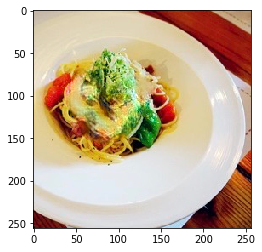

In [9]:
gen_image = test(image, mask)
plt.imshow(gen_image)

In [10]:
api.submit_image(gen_image, ID)

Step 3: 上傳答案到 PIXNET

上傳成功
題號： 10
回答截止時間： 1536508800
所剩答題次數： 9


# Restart the kernel for the next question!